In [1]:
import os
os.environ.setdefault("XLA_FLAGS", "--xla_gpu_autotune_level=0")

'--xla_gpu_autotune_level=0'

In [2]:
import jax

jax.config.update("jax_default_matmul_precision", "float32")
jax.config.update("jax_compilation_cache_dir", "jax_xla_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")

In [3]:
import rioxarray
import xarray
import pandas

import jax.numpy as jnp
import glaunti.ti_model as model
import dataloader.dataloader as dataloader
import core.loss as loss
import core.training as training
import utils.serialise
import utils.logger
import constants

import matplotlib.pyplot as plt
import datetime
import numpy as np
import pyproj
from tqdm import tqdm

In [4]:
dataset_index = dataloader.retrieve_dataset_index()
glacier = dataset_index[dataset_index.name == "Grosser Aletsch"].iloc[0]

In [5]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, 
            static_params, 
            x, 
            initial_swe=initial_swe, 
            return_series=True, 
        ),
    ),
)
params = model.get_initial_model_parameters()
params = utils.serialise.load_pytree(f"params/a_finetuned_{glacier['name']}.eqx", template=params)
trainable_params, static_params = params

In [6]:
# run model with unchanged climate

In [7]:
swe_or_h, next_xy = loss.init_swe_or_h(
    trainable_params, static_params, model_callable, glacier["name"], False, False, last_numpy=False
)

smb_results, ts, ps, outlines_unchanged = [], [], [], []

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, 
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
        numpy=False,
    )

    if not "annual" in x:
        x["annual"] = {
            "temperature": xarray.concat(
                [x["winter"]["temperature"], x["summer"]["temperature"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
            "precipitation": xarray.concat(
                [x["winter"]["precipitation"], x["summer"]["precipitation"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
        }

    ts.append(x["annual"]["temperature"])
    ps.append(x["annual"]["precipitation"])
    outlines_unchanged.append(x["outlines"])

    x = dataloader.x_to_raw_numpy(x)
    x.update(x["annual"])
    smb, swe_or_h = model_callable(trainable_params, static_params, x, swe_or_h)
    smb_results.append(np.array(smb))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.87it/s]


In [8]:
# compile unchanged results
glacier_smb_unchanged, glacier_t_unchanged, glacier_p_unchanged = [], [], []
total_smb_unchanged = None
for smb, t, p, gm in zip(smb_results, ts, ps, outlines_unchanged):
    smb_xr = t.copy()
    smb_xr.data = smb
    smb_xr = smb_xr.rename("smb")
    if total_smb_unchanged is None:
        total_smb_unchanged = smb_xr.sum(dim="time")
    else:
        total_smb_unchanged += smb_xr.sum(dim="time")
    gm_sum = gm.sum()
    glacier_smb_unchanged.append((smb_xr * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_t_unchanged.append((t * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_p_unchanged.append((p * gm).sum(dim=("x", "y")) / gm_sum)

glacier_smb_unchanged = xarray.concat(glacier_smb_unchanged, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_t_unchanged = xarray.concat(glacier_t_unchanged, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_p_unchanged = xarray.concat(glacier_p_unchanged, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_smb_cum_unchanged = glacier_smb_unchanged.cumsum(dim="time")
    
del smb_results, ts, ps

In [9]:
# inverse modelling to determine delta_T

In [10]:
def init_swe_or_h(
    params, 
    model_callable, 
    glacier_name=glacier["name"], 
    last_numpy=True,
    device_to_prefetch=None,
):
    swe_or_h = None

    next_xy = dataloader.prefetch_xy(
        glacier_name, 
        constants.initialisation_period_start_year, 
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
    )
    for year in range(constants.initialisation_period_start_year, 2015):
        x, y = next_xy.get()
        next_xy = dataloader.prefetch_xy(
            glacier_name, year + 1, 
            retrieve_corrector_predictors=False, 
            retrieve_facies=False,
            numpy=((year + 1 < constants.study_period_start_year) or last_numpy),
            device=device_to_prefetch,
        )

        if not "winter" in x:
            x_annual = dict(x)
            x_annual.update(x_annual["annual"])
            _, swe_or_h = model_callable({}, params, x_annual, swe_or_h)
            
        else:
            x_winter = dict(x)
            x_winter.update(x_winter["winter"])
            _, swe_or_h = model_callable({}, params, x_winter, swe_or_h)

            x_summer = dict(x)
            x_summer.update(x_summer["summer"])
            _, swe_or_h = model_callable({}, params, x_summer, swe_or_h)
    
    return swe_or_h, next_xy

In [11]:
def loss_inv(
    dt,
    params, model_callable, glacier, 
    device_to_prefetch=None,
):       
    glacier_name, max_year, aux = glacier["name"], glacier["max_year"], {}
    swe_or_h, next_xy = init_swe_or_h(params, model_callable, glacier_name, device_to_prefetch=device_to_prefetch)
    
    n, average_glacier_smb = 0.0, 0.0
    for year in range(2015, max_year + 1):
        x, y = next_xy.get()
        next_xy = dataloader.prefetch_xy(
            glacier_name, year + 1, geometry_year=min(year + 1, 2020),
            retrieve_corrector_predictors=False, 
            retrieve_facies=False,
            device=device_to_prefetch,
        )
        
        if "annual" in x:
            x_annual = dict(x)
            x_annual.update(x_annual["annual"])
            x_annual["temperature"] = x_annual["temperature"] + dt
            smb_annual, swe_or_h = model_callable({}, params, x_annual, swe_or_h)
            
        else:
            x_winter = dict(x)
            x_winter.update(x_winter["winter"])
            x_winter["temperature"] = x_winter["temperature"] + dt
            smb_winter, swe_or_h = model_callable({}, params, x_winter, swe_or_h)

            x_summer = dict(x)
            x_summer.update(x_summer["summer"])
            x_summer["temperature"] = x_summer["temperature"] + dt
            smb_summer, swe_or_h = model_callable({}, params, x_summer, swe_or_h)
            smb_annual = smb_winter + smb_summer

        if year >= 2020:
            glacier_smb = jnp.sum(smb_annual * x["outlines"]) / jnp.sum(x["outlines"])
            average_glacier_smb += glacier_smb
            n += 1.0

    average_glacier_smb = average_glacier_smb / n
    aux["average_glacier_smb"] = average_glacier_smb

    loss = 1e-4 * jnp.square(dt) + jnp.square(average_glacier_smb)
    return loss, aux

In [12]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, 
            static_params, 
            x, 
            initial_swe=initial_swe, 
            return_series=False, 
        ),
    ),
)

dt = jnp.array(0.0)
best_dt, best_avg_smb = None, np.inf 
loss_grad = jax.value_and_grad(loss_inv, argnums=0, has_aux=True)
optimiser = training.get_optimiser(5e-2)
opt_state = optimiser.init(dt)
params = {**trainable_params, **static_params}
device = jax.devices()[0]

with tqdm(total=200, desc="") as pbar:
    for epoch in range(200):
        (loss_value, aux), grads = loss_grad(
            dt, params, model_callable, glacier, device_to_prefetch=device,
        )            

        avg_smb = aux["average_glacier_smb"]
        if abs(avg_smb) < best_avg_smb:
            best_avg_smb = abs(avg_smb)
            best_dt = dt
        
        dt, opt_state = training.make_step(optimiser, grads, dt, opt_state)
        pbar_desc = f"loss={loss_value:.3f}, dt={dt:.3f} deg C, avg_smb={avg_smb:.3f} m w.e."

        pbar.set_description(f"{pbar_desc}")
        pbar.update(1)

loss=0.001, dt=-2.424 deg C, avg_smb=-0.000 m w.e.: 100%|█████████████████████████████████████████| 200/200 [01:13<00:00,  2.73it/s]


In [13]:
dt_np = np.array(best_dt)
dt_np

array(-2.424369, dtype=float32)

In [14]:
# run model

In [15]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, 
            static_params, 
            x, 
            initial_swe=initial_swe, 
            return_series=True, 
        ),
    ),
)

In [16]:
swe_or_h, next_xy = loss.init_swe_or_h(
    trainable_params, static_params, model_callable, glacier["name"], False, False, last_numpy=False
)

smb_results, ts, ps, outlines = [], [], [], []
change_start_time_val = None

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, geometry_year=min(year + 1, 2020),
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
        numpy=False,
    )

    dt_y = 0.0 if year < 2015 else dt_np
    
    if not "annual" in x:
        x["annual"] = {
            "temperature": xarray.concat(
                [x["winter"]["temperature"], x["summer"]["temperature"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
            "precipitation": xarray.concat(
                [x["winter"]["precipitation"], x["summer"]["precipitation"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
        }

    if year >= 2015 and change_start_time_val is None:
        change_start_time_val = x["annual"]["temperature"]["time"].values[0]
    
    x["annual"]["temperature"] = x["annual"]["temperature"] + dt_y
    ts.append(x["annual"]["temperature"])
    ps.append(x["annual"]["precipitation"])
    outlines.append(x["outlines"])

    x = dataloader.x_to_raw_numpy(x)
    x.update(x["annual"])
    smb, swe_or_h = model_callable(trainable_params, static_params, x, swe_or_h)
    smb_results.append(np.array(smb))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.94it/s]


In [17]:
# compile results
glacier_smb, glacier_t, glacier_p = [], [], []
total_smb = None
for smb, t, p, gm in zip(smb_results, ts, ps, outlines):
    smb_xr = t.copy()
    smb_xr.data = smb
    smb_xr = smb_xr.rename("smb")
    if total_smb is None:
        total_smb = smb_xr.sum(dim="time")
    else:
        total_smb += smb_xr.sum(dim="time")
    gm_sum = gm.sum()
    glacier_smb.append((smb_xr * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_t.append((t * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_p.append((p * gm).sum(dim=("x", "y")) / gm_sum)

glacier_smb = xarray.concat(glacier_smb, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_t = xarray.concat(glacier_t, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_p = xarray.concat(glacier_p, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_smb_cum = glacier_smb.cumsum(dim="time")

glacier_smb = glacier_smb.where(glacier_smb.time >= change_start_time_val, drop=True)
glacier_t = glacier_t.where(glacier_t.time >= change_start_time_val, drop=True)
glacier_p = glacier_p.where(glacier_p.time >= change_start_time_val, drop=True)
glacier_smb_cum = glacier_smb_cum.where(glacier_smb.time >= change_start_time_val, drop=True)
    
del smb_results, ts, ps

In [18]:
# plot the results

In [19]:
import matplotlib.pyplot as plt
import matplotlib_scalebar.scalebar
import matplotlib.lines
import scipy
import json

In [20]:
hillshade = None
hillshade_path = f"{glacier['name']}_hillshade.tif"
if os.path.exists(hillshade_path):
    hillshade = rioxarray.open_rasterio(hillshade_path)[0]

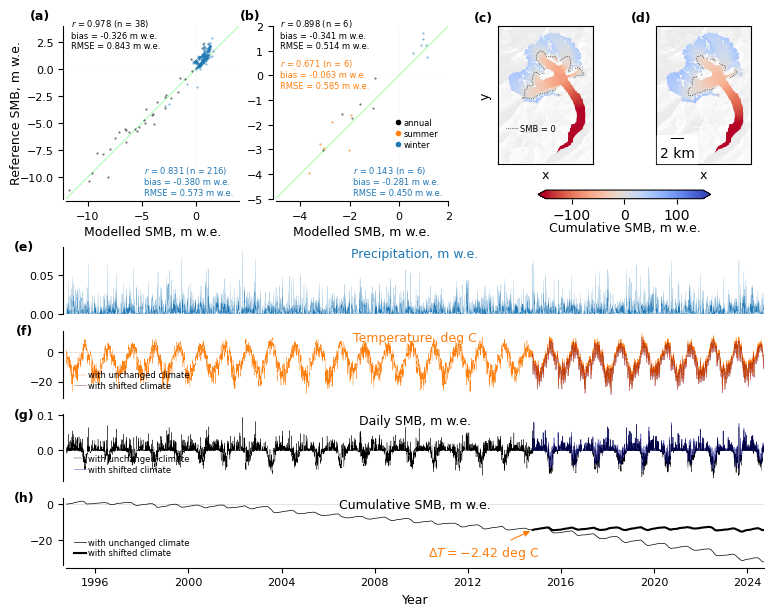

In [22]:
fig = plt.figure(figsize=(9, 7))

# Outer 2x4 grid
gs = fig.add_gridspec(5, 4, width_ratios=[1, 1, 0.7, 0.7], height_ratios=[1, 0.25, 0.25, 0.25, 0.25], wspace=0.25, hspace=0.7)
gs_sub = gs[1:, :].subgridspec(4, 1, wspace=0, hspace=0.25)

# Top: 4 axes
ax_t1 = fig.add_subplot(gs[0, 0])
ax_t2 = fig.add_subplot(gs[0, 1])
ax_t3 = fig.add_subplot(gs[0, 2])
ax_t4 = fig.add_subplot(gs[0, 3])

# Long hor axes
ax_daily_p = fig.add_subplot(gs_sub[0])
ax_daily_t = fig.add_subplot(gs_sub[1])
ax_daily_smb = fig.add_subplot(gs_sub[2])
ax_cum_smb = fig.add_subplot(gs_sub[3])
for ax in [ax_daily_smb, ax_daily_t, ax_daily_p, ax_cum_smb]:
    ax.set_rasterized(True)


def make_scatter(ax, glacier, estimation_type, start_year=2019, end_year=2025, alpha_factor=2):
    # read x, y
    true_pred = {s: {"true": [], "pred": []} for s in ["annual", "winter", "summer"]}
    eval_path = f"eval/a_finetuned/{glacier['name']}.json"
    with open(eval_path, "r") as src:
        evaluation = json.load(src)
    for year in range(start_year, end_year):
        for s in ["annual", "winter", "summer"]:
            if str(year) in evaluation["true_pred"][estimation_type]["per_year"][s].keys():
                true_pred[s]["true"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["true"])
                true_pred[s]["pred"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["pred"])
    # make plot and labels
    # annual
    true, pred = np.array(true_pred["annual"]["true"]), np.array(true_pred["annual"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="black", alpha=min(0.4 * alpha_factor, 1.0), zorder=-5, s=0.15, label="annual")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 1.05, report, ha="left", va="top", transform=ax.transAxes, size=6, color="black", zorder=10)
    # winter
    true, pred = np.array(true_pred["winter"]["true"]), np.array(true_pred["winter"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C0", alpha=min(0.4 * alpha_factor, 1.0), zorder=-3, s=0.15, label="winter")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.45, 0.20, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C0", zorder=10)
    # summer
    true, pred = np.array(true_pred["summer"]["true"]), np.array(true_pred["summer"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C1", alpha=min(0.6 * alpha_factor, 1.0), zorder=-4, s=0.15, label="summer")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 0.82, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C1", zorder=10)
        

make_scatter(ax_t1, glacier, "point")
make_scatter(ax_t2, glacier, "glacier-wide")

vmin, vmax = -150, 150
im = total_smb_unchanged.plot.imshow(
    ax=ax_t3, cmap="coolwarm_r", vmin=vmin, vmax=vmax, alpha=outlines_unchanged[-1],
    add_colorbar=False,
)
total_smb_unchanged_masked = total_smb_unchanged.where(outlines_unchanged[-1] > 0)
total_smb_unchanged_masked.plot.contour(
    ax=ax_t3, levels=[0], colors="black", linestyles="dotted", linewidths=0.5, zorder=5, 
)
total_smb.plot.imshow(
    ax=ax_t4, cmap="coolwarm_r", vmin=vmin, vmax=vmax, alpha=outlines[-1],
    add_colorbar=False,
)
total_smb_masked = total_smb.where(outlines[-1] > 0)
total_smb_masked.plot.contour(
    ax=ax_t4, levels=[0], colors="black", linestyles="dotted", linewidths=0.5, zorder=5, 
)
for ax in [ax_t3, ax_t4]:
    if hillshade is not None:
        hillshade.plot.imshow(ax=ax, cmap="Grays", alpha=0.08, zorder=-1, add_colorbar=False)
    ax.set_aspect(1)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_rasterized(True)
scalebar = matplotlib_scalebar.scalebar.ScaleBar(1, loc="lower left")
ax_t4.add_artist(scalebar)
cbar = fig.colorbar(im, ax=[ax_t3, ax_t4], orientation="horizontal", extend="both", fraction=0.05, pad=0.15)
cbar.set_label("Cumulative SMB, m w.e.", size=9, labelpad=-1)
zero_line = matplotlib.lines.Line2D([0], [0], color="black", linestyle="dotted", lw=0.5, label="SMB = 0")
ax_t3.legend(handles=[zero_line], loc=(0.05, 0.2), handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6)


time_vals = glacier_smb_unchanged["time"].values
ax_daily_p.plot(time_vals, glacier_p_unchanged, color="C0", linewidth=0.1)
ax_daily_t.plot(time_vals, glacier_t_unchanged, color="C1", linewidth=0.25, label="with unchanged climate")
ax_daily_smb.plot(time_vals, glacier_smb_unchanged, color="black", linewidth=0.25, label="with unchanged climate")

time_vals_changed = glacier_smb["time"].values
ax_daily_t.plot(time_vals_changed, glacier_t, color="darkred", alpha=0.5, linewidth=0.5, label="with shifted climate")
ax_daily_smb.plot(time_vals_changed, glacier_smb, color="darkblue", alpha=0.5, linewidth=0.5, label="with shifted climate")


ax_cum_smb.plot(time_vals, glacier_smb_cum_unchanged, color="black", linewidth=0.5, label="with unchanged climate")
ax_cum_smb.plot(time_vals_changed, glacier_smb_cum, color="black", linewidth=1.5, label="with shifted climate")
ax_cum_smb.annotate(
    f"$\\Delta T = {dt_np:.2f}$ deg C",
    xy=(time_vals_changed[0], glacier_smb_cum[0]), 
    xytext=(5, -10), 
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="-|>",
        lw=0.8,
        color="C1",
    ),
    color="C1",
    size=9,
    ha="right",
    va="top",
)

# labels and style
ax_t1.text(-0.25, 0.5, "Reference SMB, m w.e.", ha="right", va="center", transform=ax_t1.transAxes, size=9, rotation="vertical")
for ax in [ax_t1, ax_t2]:
    ax.text(0.5, -0.15, "Modelled SMB, m w.e.", ha="center", va="top", transform=ax.transAxes, size=9)
ax_t3.text(-0.07, 0.5, "y", ha="right", va="center", transform=ax_t3.transAxes, size=9, rotation="vertical")
for ax in [ax_t3, ax_t4]:
    ax.text(0.5, -0.03, "x", ha="center", va="top", transform=ax.transAxes, size=9)
    ax.set_xticks([])
    ax.set_yticks([])

ax_cum_smb.set_xlabel("Year", size=9)
ax_daily_smb.text(0.5, 1.0, "Daily SMB, m w.e.", ha="center", va="top", transform=ax_daily_smb.transAxes, size=9)
ax_cum_smb.text(0.5, 1.0, "Cumulative SMB, m w.e.", ha="center", va="top", transform=ax_cum_smb.transAxes, size=9)
ax_daily_t.text(0.5, 1.0, "Temperature, deg C", color="C1", ha="center", va="top", transform=ax_daily_t.transAxes, size=9)
ax_daily_p.text(0.5, 1.0, "Precipitation, m w.e.", color="C0", ha="center", va="top", transform=ax_daily_p.transAxes, size=9)


for i_ax, ax in enumerate([ax_t1, ax_t2, ax_daily_smb, ax_daily_p, ax_daily_t, ax_cum_smb]):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 2))
    if i_ax not in {2, 3, 4}:
        ax.spines["bottom"].set_position(("outward", 2))
    else:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])

for ax in [ax_t1, ax_t2]:
    ax.axline((0, 0), slope=1, color=[0.0, 1.0, 0.0, 0.5], zorder=-10, linewidth=0.5)
    ax.axvline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
for ax in [ax_daily_t, ax_daily_smb, ax_cum_smb]:
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.5)

ax_t1.set_xlim(-12, 4)
ax_t1.set_ylim(-12, 4)
ax_t2.set_xlim(-5, 2)
ax_t2.set_ylim(-5, 2)
for ax in [ax_daily_smb, ax_daily_t, ax_daily_p, ax_cum_smb]:
    ax.set_xlim(time_vals[0], time_vals[-1])
ax_daily_p.set_ylim(0.0)

for ax in [ax_t1, ax_t2, ax_daily_smb, ax_daily_t, ax_daily_p, ax_cum_smb]:
    ax.tick_params(axis="both", labelsize=8)
for i_ax, ax in enumerate([ax_t1, ax_t2, ax_t3, ax_t4, ax_daily_p, ax_daily_t, ax_daily_smb, ax_cum_smb]):
    panel_label = f"({chr(ord('a') + i_ax)})"
    x, y = (-0.15, 1.06) if i_ax in {0, 1, 2, 3} else (-0.060, 1.0)
    ax.text(x, y, panel_label, weight="bold", ha="center", va="center", transform=ax.transAxes, size=9)

legend_handles = [matplotlib.lines.Line2D(
    [], [], 
    marker="o", 
    color=c, 
    linestyle="none",
    markersize=3,
    markerfacecolor=c,
    alpha=1.0,
) for c in ["black", "C1", "C0"]]
ax_t2.legend(handles=legend_handles, labels=["annual", "summer", "winter"], handletextpad=0.0, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6, loc=(0.65, 0.27))
ax_cum_smb.legend(handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6)
ax_daily_t.legend(loc="lower left", handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6)
ax_daily_smb.legend(loc="lower left", handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6)

plt.savefig(f"figures/inverse_modelling.pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()